In [1]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from concurrent.futures import ProcessPoolExecutor

In [2]:
def integrand(x, xw, xp, ri, Mi):
    p = np.exp(-xp * ri * (xw - x))
    integrand_value = np.exp(x) * p * ((1 - p) ** (Mi - 1))
    return integrand_value


def probability(xw, xp, ri, Mi):
    factor_up_front = 1.0 / (np.exp(xw) - 1)
    integral = quad(
        integrand,
        0,
        xw,
        args=(xw, xp, ri, Mi),
        limit=200,
        epsabs=1e-10,
        epsrel=1e-10,
    )[0]
    return factor_up_front * integral
probability = np.vectorize(probability)

The ``probability`` function calculates the likelihood of a TCR proliferating based on its waiting time, proliferation rate, propensity, and expected clone size.

Parameters:

xw: The waiting time for the TCR.

xp: The proliferation rate of the TCR.

ri: The propensity to proliferate for the TCR.

Mi: The observed or expected clone size.

In [3]:

def neg_likelihood(
    params, fixed_xw, clone_count_values, r_values, verbose=False
):
    # params is now just xp, fixed_xw is provided separately
    xp = params[0]  # params is now a 1D array with just xp
    xw = fixed_xw
    n = len(clone_count_values)
    xp_values = np.full(n, xp)
    xw_values = np.full(n, xw)
    
    probs = probability(xw_values, xp_values, r_values, clone_count_values)
    # Replace zero values with the smallest positive value allowed in Python
    smallest_positive_value = np.finfo(float).eps
    probabilities = np.where(probs == 0, smallest_positive_value, probs)
    sum_log_probs = np.sum(np.log(probabilities))
    neg_sum = -sum_log_probs

    if verbose:
        print(f"Neg-logL: {neg_sum:.8f}")
        print(f"xp: {xp:.8f}")
        print(f"=" * 80)
    return neg_sum

The neg_likelihood function computes the negative log-likelihood for a collection of TCRs in a patient/datset provided parameters and observed data. Here's a detailed breakdown of its purpose and functionality:

Parameters:
params: This is expected to be a list or array containing the parameters for the model. In this case, it primarily contains the proliferation rate (xp).
fixed_xw: This is the fixed waiting time for the TCR, which is provided separately and remains constant during the optimization process.
clone_count_values: This represents the observed counts of TCR clones, which are used to evaluate the model's fit to the data. It is an 1D-array.
r_values: These are the propensity values for the TCRs, which are also used in the probability calculations.1D-array.
verbose: A boolean flag that, when set to True, enables the function to print detailed output about the negative log-likelihood and the current parameter values.

Context:
The neg_likelihood function is typically used in statistical modeling and optimization contexts, particularly in fitting models to data. By minimizing the negative log-likelihood, one can find the parameter values that best explain the observed data.
In summary, the neg_likelihood function calculates the negative log-likelihood of a statistical model based on the proliferation rate and other parameters, allowing for optimization and fitting of the model to observed TCR clone data.

In [4]:
def run_optimization(
    clone_count_values,
    r_values,
    fixed_xw,
    bounds=((1e-10, 100),),
    initial_guess=[5],
    verbose=False,
):
    bounds = [bounds[0]]
    initial_guess = initial_guess
    result = minimize(
        neg_likelihood,
        initial_guess,
        args=(fixed_xw, clone_count_values, r_values, verbose),
        method="Nelder-Mead",
        bounds=bounds,
    )
    xp = result.x[0]
    return fixed_xw, xp, initial_guess[0], result.fun

The ``run_optimization`` function is designed to optimize the proliferation rate of T-cell receptors (TCRs) based on observed clone count data. Here's a detailed breakdown of its purpose and functionality:
Parameters:

clone_count_values: This is an array or list of observed counts of TCR clones, which the optimization will aim to fit.

r_values: This likely represents the scaled propensity values for the TCRs, which are used in the likelihood calculations.

fixed_xw: This is the fixed waiting time for the TCR, which remains constant during the optimization process.

bounds: This is a tuple defining the bounds for the proliferation rate (xp). The default is set to a range between 0 and 100.

initial_guess: This is the initial guess for the proliferation rate, with a default value of `[5]`.

verbose: A boolean flag that, when set to True, enables the function to print detailed output during the optimization process.

Functionality:
The function first sets the bounds to only include the first element of the provided bounds tuple, which is the range for xp.
It then initializes the initial_guess for the optimization.
The core of the function uses the minimize function from a numerical optimization library (we use `scipy.optimize`) to minimize the negative log-likelihood calculated by the neg_likelihood function.
The minimize function is called with the following parameters:
The objective function to minimize (neg_likelihood).
The initial guess for the proliferation rate.
Additional arguments for the neg_likelihood function, including fixed_xw, clone_count_values, r_values, and verbose.
The optimization method specified as "Nelder-Mead", which is a simplex algorithm for multidimensional unconstrained optimization.
The bounds for the optimization.

After the optimization process, the function extracts the optimized proliferation rate (xp) from the result.
Finally, it returns the fixed waiting time (fixed_xw), the optimized proliferation rate (xp), the initial guess, and the final value of the minimized function (negative log-likelihood).

## Sample Data

In [5]:
#Here we pull sample data. We take 'BrMET008_region1' as sample patient region.
data = pd.read_csv('BrMET008_region1.csv', sep=',')
data.head()

,CDR3,r_i,counts
0,CAFRAKLNNYGYTF,17.188025,1
1,CAFRTWRPQETQYF,23.242105,1
2,CAFSSGRGYEQYF,38.622536,1
3,CAIRDPGAEVSYTF,28.988109,2
4,CAIRDSPGSYNEQFF,39.799374,2


In [6]:
# Here we show how to run optimization and extract optimum parameters.
clone_count_values = data['counts'].values
scaling_constant = 223.63591068
r_values = data['r_i'].values/scaling_constant
xw_opt, xp_opt, _, neg_logl = run_optimization(clone_count_values=clone_count_values, r_values=r_values, fixed_xw=100, verbose=True)

Neg-logL: 690.05844956
xp: 5.00000000
Neg-logL: 695.92226031
xp: 5.25000000
Neg-logL: 684.50353974
xp: 4.75000000
Neg-logL: 679.32394002
xp: 4.50000000
Neg-logL: 670.43290174
xp: 4.00000000
Neg-logL: 664.28916119
xp: 3.50000000
Neg-logL: 666.91266987
xp: 2.50000000
Neg-logL: 662.32075601
xp: 3.00000000
Neg-logL: 666.91266987
xp: 2.50000000
Neg-logL: 662.66385254
xp: 3.25000000
Neg-logL: 663.59016065
xp: 2.75000000
Neg-logL: 662.31352304
xp: 3.12500000
Neg-logL: 662.66385254
xp: 3.25000000
Neg-logL: 662.26984665
xp: 3.06250000
Neg-logL: 662.32075601
xp: 3.00000000
Neg-logL: 662.28020046
xp: 3.09375000
Neg-logL: 662.28313328
xp: 3.03125000
Neg-logL: 662.27211103
xp: 3.07812500
Neg-logL: 662.27349201
xp: 3.04687500
Neg-logL: 662.27024545
xp: 3.07031250
Neg-logL: 662.27092526
xp: 3.05468750
Neg-logL: 662.26986204
xp: 3.06640625
Neg-logL: 662.27020061
xp: 3.05859375
Neg-logL: 662.26980826
xp: 3.06445312
Neg-logL: 662.26986204
xp: 3.06640625
Neg-logL: 662.26981593
xp: 3.06347656
Neg-logL: 66

The block below defines two functions, `calc_probs_for_single_tcr` and `calc_probs_for_every_tcr`, which are used to compute the probability distributions of clone sizes for every observed unique T-cell receptors (TCRs) based on model parameters.
1. `calc_probs_for_single_tcr`
Purpose:
Calculates the probability distribution of clone sizes for a single TCR, given its propensity (ri), waiting time (xw), proliferation rate (xp), and the user given maximum clone size (maxM).
How it works:
It returns a list of probabilities, where each entry corresponds to the probability of observing a clone size from 1 up to maxM, as computed by the probability function.
2. `calc_probs_for_every_tcr`
Purpose:
Efficiently computes the probability distributions for all TCRs in a dataset, leveraging parallel processing for speed.
How it works:
Takes an array of propensities (r), corresponding for each TCR and calculates their probability distribution using `calc_probs_for_single_tcr`.
Uses Python’s `ProcessPoolExecutor` to parallelize the computation across multiple CPU cores, which is especially useful when dealing with large datasets.
Progress is tracked using `tqdm` for a visual progress bar.
The results are collected into a 2D NumPy array, where each row corresponds to a TCR and each column to the probability of clone sizes ranging from 1 to `maxM`.
If the input is not a 1D array, it raises a ValueError to ensure correct usage.
Summary:
These functions are essential for simulating or analyzing the expected clone size distributions for a population of TCRs, given model parameters, and are optimized for performance using parallel computation.

In [7]:
def calc_probs_for_single_tcr(ri, xw, xp, maxM):
    return [probability(xw, xp, ri, M) for M in range(1, maxM + 1)]


def calc_probs_for_every_tcr(r, xw, xp, maxM, disable_progressbar=False):
    if isinstance(r, np.ndarray) and r.ndim == 1:
        with ProcessPoolExecutor(max_workers=min(len(r), 30)) as executor:
            # Submit all tasks and get futures
            futures = [
                executor.submit(calc_probs_for_single_tcr, r_i, xw, xp, maxM)
                for r_i in r
            ]
            # Use tqdm to track completion of futures
            results = list(
                tqdm.tqdm(
                    (future.result() for future in futures),
                    total=len(r),
                    desc="Processing TCRs",
                    disable=disable_progressbar,
                )
            )
        return np.array(results)
    else:
        raise ValueError("kr must be 1D array or a 1D list.")

In [8]:
ri_for_first_tcr = data['r_i'].values[0]
probs = calc_probs_for_single_tcr(ri_for_first_tcr/scaling_constant, xw_opt, xp_opt, 1000)
print(f'probs_for first TCR = {np.sum(probs):.2f}')

probs_for first TCR = 1.00


##### In the above block of execution, note that we check of the sum of the probabilities calculated for the TCR between 1 and maxM=1000 sum to 1. We recommend to choose a large value of maxM (at least 1 order higher than the order of maximum observed clone size) as it ensures the probabilities sum to 1 for all the observed TCRs.

In [9]:
ri_for_all_tcrs = data['r_i'].values
probs_ = calc_probs_for_every_tcr(ri_for_all_tcrs/scaling_constant, xw_opt, xp_opt, 1000, disable_progressbar=False)
print(probs_.shape)

Processing TCRs: 100%|██████████| 654/654 [00:31<00:00, 20.71it/s]


(654, 1000)


### Given the probability arrray `probs_` calculated above which is of shape (number_of_tcrs, range(1, maxM+1)), the code block below has a function 'generate_configuration' which generates configuration for each tcr (row in `probs_`) between minimum clone size  `min_clone_size` and maximum clone size `max_clone_size` from the probability values corresponding to each row. The `sample_size` argument allows to choose the number of clones to generate in one configuration. The `disable_progressbar` allows you to track the progress of generating the configuration.

In [10]:
def generate_configuration(
    prob_array,
    min_clone_size=1,
    max_clone_size=None,
    sample_size=1,
    disable_progressbar=False,
):
    if prob_array.ndim == 1:
        assert max_clone_size == min_clone_size + len(
            prob_array
        ), f"max_clone_size ({max_clone_size}) must equal min_clone_size ({min_clone_size}) + len(prob_array) ({len(prob_array)})"
        config_per_tcr = np.random.choice(
            range(min_clone_size, len(prob_array) + min_clone_size),
            size=sample_size,
            replace=True,
            p=prob_array / sum(prob_array),
        )
        return config_per_tcr
    elif prob_array.ndim == 2:  # Ensure we only handle 1D and 2D arrays
        assert (
            max_clone_size == min_clone_size + prob_array.shape[1]
        ), f"max_clone_size ({max_clone_size}) must equal min_clone_size ({min_clone_size}) + prob_array.shape[1] ({prob_array.shape[1]})"

        all_configs = np.empty((prob_array.shape[0], sample_size))
        for i in tqdm.tqdm(
            range(prob_array.shape[0]),
            total=prob_array.shape[0],
            desc="Generating configuration for each TCR",
            leave=True,
            disable=disable_progressbar,
        ):
            # config_per_tcr = generate_configuration_per_tcr(prob_array[i, :], size)
            config_per_tcr = np.random.choice(
                range(min_clone_size, prob_array.shape[1] + min_clone_size),
                size=sample_size,
                replace=True,
                p=prob_array[i, :] / sum(prob_array[i, :]),
            )
            all_configs[i, :] = config_per_tcr
        return all_configs
    else:
        raise ValueError("Input array must be either 1D or 2D.")

In [11]:
model_config = generate_configuration(probs_, min_clone_size=1, max_clone_size=probs_.shape[1]+1, sample_size=1000, disable_progressbar=False)
print(model_config.shape)

Generating configuration for each TCR: 100%|██████████| 654/654 [00:00<00:00, 8101.82it/s]

(654, 1000)


##### As you can see above, for BrMET008-region1 there are 654 unique TCRs and the above function generated configuration for each tcr rowwise with a sample size of 1000. We now consider that each column each a possible configuration likely to be observed as model generated. Hence there are 1000 configurations we have generated.

##### The code block below then processes above configuration to calculate confidence interval at each generated clone size with following restrictions:
1. A clone size has to be observed at least `least_number_of_observations` times. We choose this value to be 10.
At each generated clone size, the confidence interval is central 95% mass of probabilities for the respective clone size obtained from `sample_size=1000` configurations we generated.

In [14]:
def process_column(col_data):
    values, probabilities = np.unique(col_data, return_counts=True)
    return values, probabilities/sum(probabilities)

def ci_pdf(configs, alpha=5, least_number_of_observations=1):

    # configs must be a two dimensional array of shape (#tcr, #configs per tcr)
    if configs.ndim >= 2:
        pdf_dict = {}

        # Use ProcessPoolExecutor to parallelize the processing of columns
        with ProcessPoolExecutor() as executor:
            results = list(
                executor.map(
                    process_column, [configs[:, col] for col in range(configs.shape[1])]
                )
            )

        # Iterate over the results and populate the pdf_dict
        for values, probabilities in results:
            for value, probability in zip(values, probabilities):
                if value not in pdf_dict:
                    pdf_dict[value] = []
                pdf_dict[value].append(probability)

        # Calculate alpha% level of significance
        confidence_intervals = {}
        for key, probs in pdf_dict.items():
            if len(probs) > least_number_of_observations:
                median_prob = np.median(probs)
                lb = np.percentile(probs, alpha / 2)
                ub = np.percentile(probs, 100 - alpha / 2)
                confidence_intervals[key] = (lb, median_prob, ub)
            else:
                continue

        df = pd.DataFrame.from_dict(
            confidence_intervals, orient="index", columns=["lower", "median", "upper"]
        )

        # Add the keys as a column named 'clone_size'
        df.reset_index(inplace=True)
        df.rename(columns={"index": "clone_size"}, inplace=True)

        # Order the rows in increasing clone size
        df.sort_values(by="clone_size", inplace=True)

        if df.empty:
            raise ValueError("The resulting DataFrame is empty.")
        else:
            return df
    else:
        raise ValueError("CI cannot be calculated for single configuration.")

In [15]:
ci_df = ci_pdf(model_config, alpha=5, least_number_of_observations=10)
ci_df.head()

,clone_size,lower,median,upper
0,1.0,0.681957,0.715596,0.747706
1,2.0,0.126911,0.152905,0.183486
2,3.0,0.039755,0.055046,0.073394
3,4.0,0.015291,0.025994,0.039755
4,5.0,0.006116,0.013761,0.024465


##### The code block below has a function `plot_pdf` which simply plots the observed data in terms of probabilities.

In [16]:
def plot_pdf(config_data, raw=True):
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(10, 5),
    )
    if raw:
        data = np.unique(config_data, return_counts=True)
        x_data, y_data = data[0], data[1] / sum(data[1])
    else:
        x_data, y_data = config_data[0], config_data[1]

    ax.scatter(
        x_data,
        y_data,
        s=50,
        facecolors="blue",
        edgecolors="blue",
        label="data",
        zorder=2,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    offset = 0.30
    ax.set_xlim(min(x_data) - offset * min(x_data), max(x_data) + offset * max(x_data))
    ax.set_ylim(min(y_data) - offset * min(y_data), max(y_data) + offset * max(y_data))

    ax.legend(loc="best")
    return fig, ax

##### Then we add the CI band in the plot as below.The data points are shown as solid blue dots and the CI is shown in blue bands. Note that the band in fact is a discrete band and any shaded region between consecutive clone sizes carry no meaning. We could have chosen to show a whisker at each clone size and considered it as a model error bar.

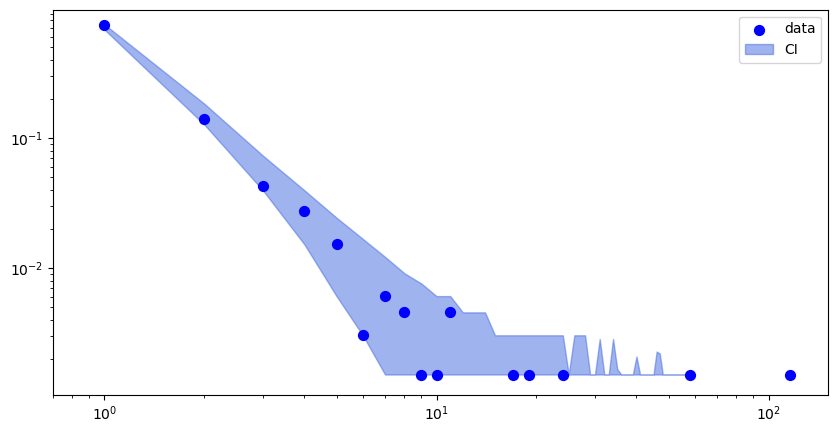

In [17]:
fig, ax = plot_pdf(clone_count_values)
ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='royalblue', alpha=0.5, label='CI')
plt.legend(loc='best')
plt.show()

# Coverage probability: This quantity is the fraction of data points that lie inside the confidence interval. Following is how we calculate the coverage probability for patient region 'BrMET008-region1" regarding the above plot.

We have the discrete observed countsfor this patient region as `clone_count_values`. We create a PDF out of it and call it `data` which we collect and frame it as a dataframe `data_df` with column names `x` and `y` where `x` contains the observed clone sizes and `y` contains the corresponding probability normalized to observed data. Then we merge `data_df` with the `ci_df` that we calculated earlier on the same observed clone sizes in the data and that appears during the generation of configuration via model. Then for each observed clone size `x` we check if the corresponding probability `y` lies inside the `95%` mass of probabilities generated at that clone size from the model. Finally we count the fraction of instances that lies inside the 95% mass per clone size.

In [18]:
data = np.unique(clone_count_values, return_counts=True)
x, y = data[0], data[1] / sum(data[1])
data_df = pd.DataFrame({'x':x, 'y':y})
new_df = pd.merge(left=ci_df, right=data_df, left_on='clone_size', right_on='x')
new_df['y_in_CI'] = (new_df['y'] >= new_df['lower']) & (new_df['y'] <= new_df['upper'])
count_inside_CI = new_df['y_in_CI'].sum()/new_df.shape[0]
print(f"Coverage probability for patient region BrMET008-region1: {count_inside_CI*100}%")

Coverage probability for patient region BrMET008-region1: 100.0%


We must have chosen an ideal case by random chance here as the coverage probability is 100%.

## Ranking the neoantigens based on the mean clone size they produce:

##### First we import the relevant data. The dataframe below has 3 columns. The first column `Peptide` contains peptide sequences. The second column `CDR3` contains TCR sequences. The 3rd column `Score` contains PanPep score for the pair of peptide and tcr correspnoding to the row.

In [31]:
panpep_score_df = pd.read_csv('BrMET008_region1_panpep_scores.csv', sep=',')
panpep_score_df.head()

,Peptide,CDR3,Score
0,YPRRIQLSRM,CAFRAKLNNYGYTF,0.254282
1,YPRRIQLSRM,CAFRTWRPQETQYF,0.320246
2,YPRRIQLSRM,CAFSSGRGYEQYF,0.495913
3,YPRRIQLSRM,CAIRDPGAEVSYTF,0.403382
4,YPRRIQLSRM,CAIRDSPGSYNEQFF,0.584113


In [20]:
unique_peptide_count = panpep_score_df['Peptide'].nunique()
unique_peptide_count

69

##### There are 69 unique peptide sequences. We then run the pipeline 'calc_probs_for_every_tcr -> generate_configuration -> mean(generated configurations)' as below for each peptide at a time. In each peptide case, the propensity values are substituted by the PanPep score values corresponding to the peptide. The score values are rescaled by the total number of unique peptides for patient region BrMET008-region1 and then divided by the same scaling constant used to scale the original propensity values.

In [21]:
peptide_vs_mean_clone_size_dict = {}
for _, (peptide, df) in tqdm.tqdm(enumerate(panpep_score_df.groupby(by='Peptide')), total=unique_peptide_count):
    r_values = df['Score'].values * unique_peptide_count
    probs_ = calc_probs_for_every_tcr(r_values/scaling_constant, xw_opt, xp_opt, 1000, disable_progressbar=False)
    model_config = generate_configuration(probs_, min_clone_size=1, max_clone_size=probs_.shape[1]+1, sample_size=1000, disable_progressbar=False)
    mean_clone_size = np.mean(model_config)
    peptide_vs_mean_clone_size_dict[peptide] = mean_clone_size
peptide_vs_mean_clone_size_dict_sorted = sorted(peptide_vs_mean_clone_size_dict.items(), key=lambda x: x[1], reverse=True)

100%|██████████| 69/69 [37:10<00:00, 32.33s/it]


##### To run the above code block it took `37` minutes using 1 node and 30 cpus. So, it is recommended to heavily parallelize the computation.
##### Below we plot the mean clone size of the TCR produced in each scenario when we substituted all of the peptides by one of the peptides.


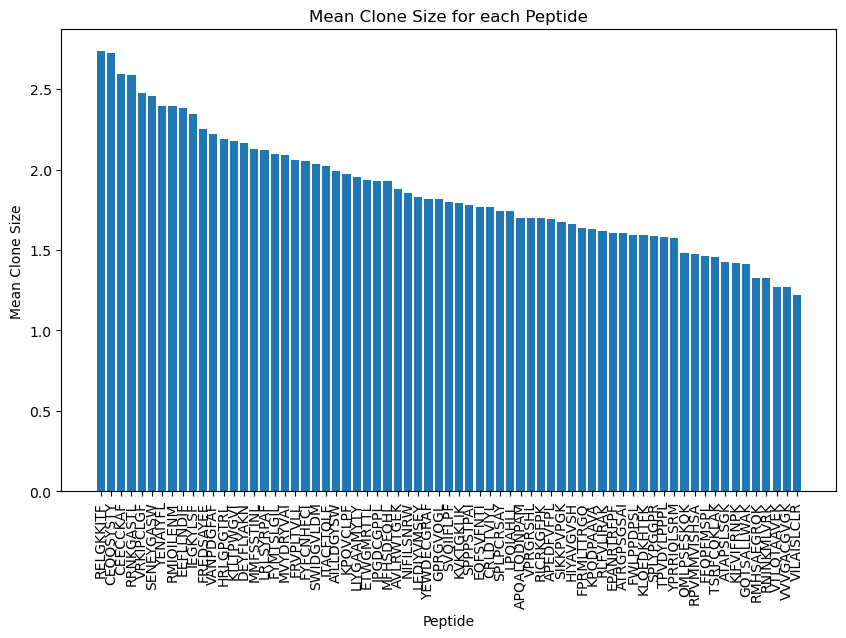

In [25]:
import matplotlib.pyplot as plt

keys = [item[0] for item in peptide_vs_mean_clone_size_dict_sorted]
values = [item[1] for item in peptide_vs_mean_clone_size_dict_sorted]

plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.xlabel('Peptide')
plt.ylabel('Mean Clone Size')
plt.title('Mean Clone Size for each Peptide')
plt.show()
